# Look at Tycho-2 - Gaia catalog (TGAS)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
import time

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(1):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']
    tgas['dec'] = tgas_tmp['dec']
    tgas['mu_ra'] = tgas_tmp['pmra']
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']
    tgas['mu_dec'] = tgas_tmp['pmdec']
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']
    tgas['plx'] = tgas_tmp['parallax']
    tgas['plx_err'] = tgas_tmp['parallax_error']

    tgas_full = np.append(tgas_full, tgas)


../data/TGAS/TgasSource_000-000-000.csv


### Let's look at TGAS catalog quality

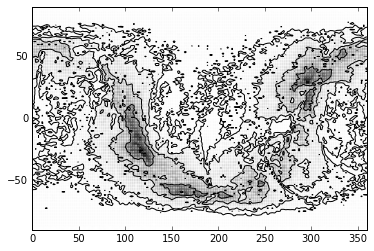

In [17]:
import corner
corner.hist2d(tgas_full['ra'], tgas_full['dec'], bins=150, plot_datapoints=False)

plt.show()

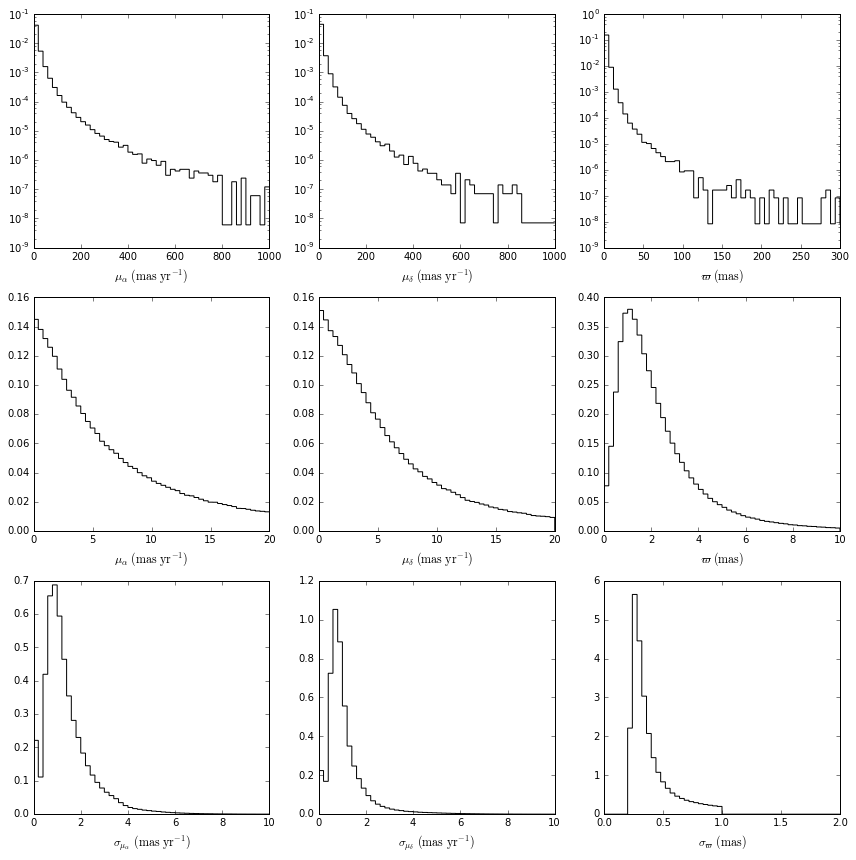

In [84]:
fig, ax = plt.subplots(3, 3, figsize=(12,12))

ax[0,0].hist(tgas_full['mu_ra'], histtype='step', color='k', bins=50, normed=True, range=(0,1000), log=True)
ax[0,1].hist(tgas_full['mu_dec'], histtype='step', color='k', bins=50, normed=True, range=(0,1000), log=True)
ax[0,2].hist(tgas_full['plx'], histtype='step', color='k', bins=50, normed=True, range=(0,300), log=True)
ax[0,0].set_xlabel(r'$\mu_{\alpha}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[0,1].set_xlabel(r'$\mu_{\delta}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[0,2].set_xlabel(r'$\varpi\ ({\rm mas})$', fontsize=12)

ax[1,0].hist(tgas_full['mu_ra'], histtype='step', color='k', bins=50, normed=True, range=(0,20))
ax[1,1].hist(tgas_full['mu_dec'], histtype='step', color='k', bins=50, normed=True, range=(0,20))
ax[1,2].hist(tgas_full['plx'], histtype='step', color='k', bins=50, normed=True, range=(0,10))
ax[1,0].set_xlabel(r'$\mu_{\alpha}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[1,1].set_xlabel(r'$\mu_{\delta}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[1,2].set_xlabel(r'$\varpi\ ({\rm mas})$', fontsize=12)

ax[2,0].hist(tgas_full['mu_ra_err'], histtype='step', color='k', bins=50, normed=True, range=(0,10))
ax[2,1].hist(tgas_full['mu_dec_err'], histtype='step', color='k', bins=50, normed=True, range=(0,10))
ax[2,2].hist(tgas_full['plx_err'], histtype='step', color='k', bins=50, normed=True, range=(0,2))
ax[2,0].set_xlabel(r'$\sigma_{\mu_{\alpha}}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[2,1].set_xlabel(r'$\sigma_{\mu_{\delta}}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[2,2].set_xlabel(r'$\sigma_{\varpi}\ ({\rm mas})$', fontsize=12)

plt.tight_layout()
plt.show()

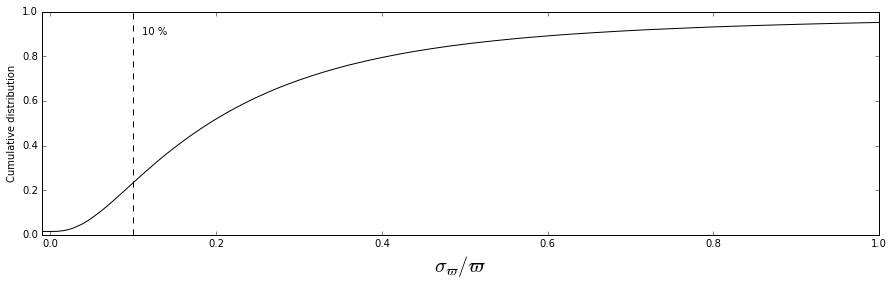

In [111]:
fig = plt.figure(figsize=(15,4))

# Cumulative distribution
plt.plot(np.sort(tgas_full['plx_err']/tgas_full['plx']), np.arange(len(tgas_full))/float(len(tgas_full)), color='k')

plt.xlabel(r'$\sigma_{\varpi} / \varpi$', fontsize=20)
plt.ylabel('Cumulative distribution')

plt.axvline(0.1, linestyle='dashed', color='k')
plt.text(0.11, 0.9, "10 %")

plt.xlim(-0.01, 1.0)

plt.show()

### Testing KDE from binaries

In [3]:
import sys
sys.path.append('../src')
import P_binary

start time: 1474288035.39
Generate binaries: 0.535210132599 seconds
Build tree: 0.0108358860016 seconds
Histogram: 0.102073907852 seconds
Default gaussian_kde: 0.404437065125 seconds


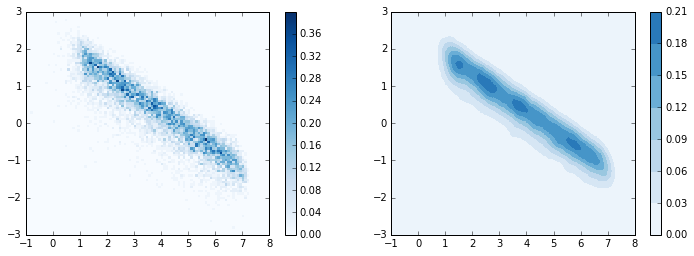

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

P_binary.binary_kde = None

start = time.time()
print "start time:", start

num_sys = 10000
P_binary.generate_binary_set(num_sys=num_sys)
mu_set = np.array([np.log10(P_binary.binary_set['proj_sep']), np.log10(P_binary.binary_set['delta_v_trans'])]).T

print "Generate binaries:", time.time()-start, "seconds"
start = time.time()

P_binary.get_P_binary(np.array([1.0, 1.0]), np.array([1.0, 0.9]))

print "Build tree:", time.time()-start, "seconds"
start = time.time()

nbins = 100
xmin, xmax = -1.0, 8.0
ymin, ymax = -3.0, 3.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T


pdf, xedges, yedges = np.histogram2d(np.log10(P_binary.binary_set["proj_sep"]), 
                                     np.log10(P_binary.binary_set["delta_v_trans"]), 
                                     normed=True,
                                     bins=[xbins,ybins])
im = ax[0].pcolormesh(xbins, ybins, pdf.T, cmap='Blues')
fig.colorbar(im, ax=ax[0])

print "Histogram:", time.time()-start, "seconds"
start = time.time()

P_binary.binary_kde = None
# kwargs = {'kernel':'tophat'}
# P_binary.binary_kde = KernelDensity(bandwidth=0.3, **kwargs)
# P_binary.binary_kde.fit( np.array([np.log10(P_binary.binary_set['proj_sep']), 
#                                    np.log10(P_binary.binary_set['delta_v_trans'])]).T )
Z = P_binary.get_P_binary(10**X.flatten(), 10**Y.flatten(), kde_method='sklearn')
#Z = P_binary.get_P_binary(10**X.flatten(), 10**Y.flatten(), kde_method='scipy')
Z = Z * 10**X.flatten() * 10**Y.flatten() * np.log(10.)**2
#im = ax[1].tricontourf(mu_grid[:,0], mu_grid[:,1], Z, cmap='Blues', extend='max')
im = ax[1].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', vmax=0.27)
#im = ax[1].tricontourf(mu_grid[:,0], mu_grid[:,1], Z, cmap='Blues')
fig.colorbar(im, ax=ax[1])

print "Default gaussian_kde:", time.time()-start, "seconds"
start = time.time()



plt.show()

In [6]:
P_binary.binary_kde = None
print P_binary.get_P_binary(1.0e5, 0.2)

[  6.45397404e-07]


/Library/Python/2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### Test KDE method on parallax data

In [3]:
import sys
sys.path.append('../src')
import P_posterior
import parallax

0.01


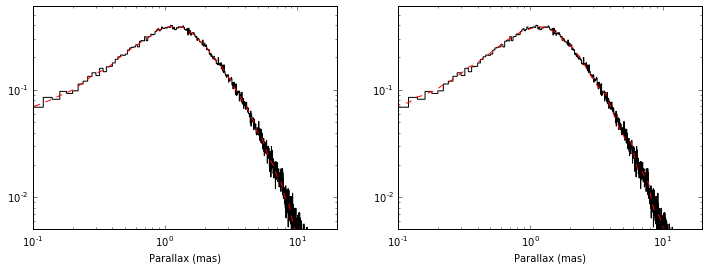

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

parallax.plx_kde = None
parallax.set_plx_kde(tgas_full, bandwidth=0.01, method='scipy_kde')
print parallax.plx_kde.covariance_factor()


xmin, xmax = 0.01, 100
x = 10**np.linspace(np.log10(xmin), np.log10(xmax), 200)
ax[0].hist(tgas_full['plx'], histtype='step', color='k', bins=10000, normed=True, range=(0,200))
ax[0].plot(x, parallax.get_plx_prior(x, method='scipy_kde'), color='r', linestyle='dashed')




parallax.plx_kde = None
parallax.set_plx_kde(tgas_full, bandwidth=0.3, method='sklearn_kde')

ax[1].hist(tgas_full['plx'], histtype='step', color='k', bins=10000, normed=True, range=(0,200))
ax[1].plot(x, parallax.get_plx_prior(x, method='sklearn_kde'), color='r', linestyle='dashed')


# Adjust all the plots
for a in ax:
    a.set_xscale('log')
    a.set_xlim(0.1,20)
    a.set_yscale('log')
    a.set_ylim(5.0e-3, 6.0e-1)
    a.set_xlabel('Parallax (mas)')

plt.show()

In [6]:
print parallax.plx_kde.bandwidth

0.1


### Now, let's test the KDE on the proper motion

In [18]:
import sys
sys.path.append('../src')
import P_random

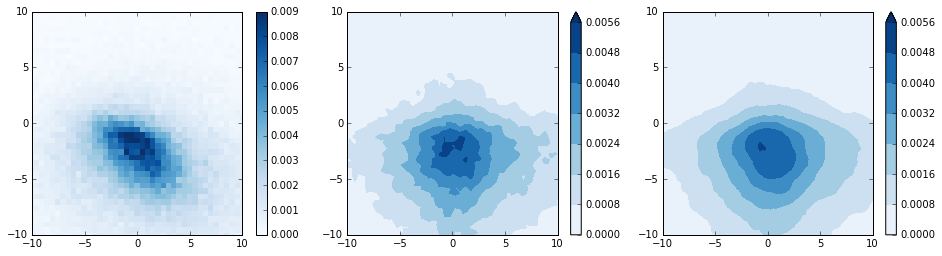

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

nbins = 200
xmin, xmax = -50.0, 50.0
ymin, ymax = -50.0, 50.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T

pdf, xedges, yedges = np.histogram2d(tgas_full['mu_ra'], 
                                     tgas_full['mu_dec'], 
                                     normed=True,
                                     bins=[xbins,ybins])

im = ax[0].pcolormesh(xbins, ybins, pdf.T, cmap='Blues', vmax=0.009)
fig.colorbar(im, ax=ax[0])


P_random.mu_kde = None
Z = P_random.get_sigma_mu(X.flatten(), Y.flatten(), catalog=tgas_full, method='sklearn_kde', bandwidth=0.5)

im = ax[1].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', extend='max')
fig.colorbar(im, ax=ax[1])



P_random.mu_kde = None
Z = P_random.get_sigma_mu(X.flatten(), Y.flatten(), catalog=tgas_full, method='sklearn_kde', bandwidth=1.0)

im = ax[2].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', extend='max')
fig.colorbar(im, ax=ax[2])


for a in ax:
    a.set_xlim(-10.0, 10.0)
    a.set_ylim(-10.0, 10.0)

plt.show()

### Finally, let's do the same analysis on position

In [3]:
import sys
sys.path.append('../src')
import P_random

start time: 1474194684.77
Build tree: 0.026046037674 seconds
Histogram: 0.117942810059 seconds
Default gaussian_kde: 16.477132082 seconds


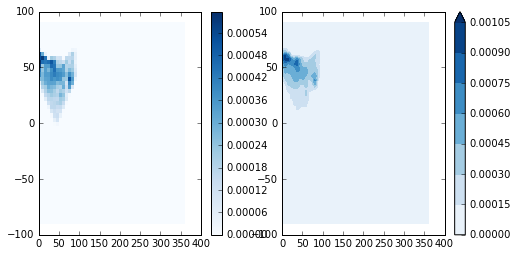

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

P_random.pos_kde = None

start = time.time()
print "start time:", start

P_random.get_sigma_pos(np.array([1.0, 2.0]), np.array([1.0, -1.0]), catalog=tgas_full)

print "Build tree:", time.time()-start, "seconds"
start = time.time()

nbins = 50
xmin, xmax = 0.0, 360.0
ymin, ymax = -90.0, 90.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T


pdf, xedges, yedges = np.histogram2d(tgas_full['ra'], 
                                     tgas_full['dec'],
                                     normed=True,
                                     bins=[xbins,ybins])
im = ax[0].pcolormesh(xbins, ybins, pdf.T, cmap='Blues')
fig.colorbar(im, ax=ax[0])

print "Histogram:", time.time()-start, "seconds"
start = time.time()

                                     
                                     
Z = P_random.get_sigma_pos(X.flatten(), Y.flatten(), catalog=tgas_full)
im = ax[1].tricontourf(mu_grid[:,0], mu_grid[:,1], Z, cmap='Blues', extend='max')
fig.colorbar(im, ax=ax[1])

print "Default gaussian_kde:", time.time()-start, "seconds"
start = time.time()



plt.show()

### Now, let's test the P_binary probabilities on an actual binary

In [15]:
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import parallax
from scipy.stats import norm, truncnorm
from numpy.random import normal
import const as c

start time: 1474213246.58
Generate binaries: 0.506572961807 seconds
Build tree: 0.00941014289856 seconds
Histogram: 0.0987448692322 seconds
sklearn: 0.340931177139 seconds
615996816.671
N_P_binary_good: 300 300


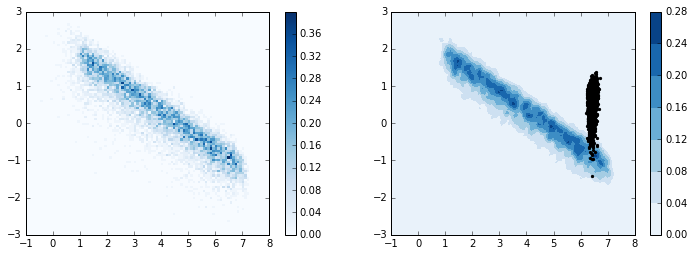

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

P_binary.binary_kde = None

start = time.time()
print "start time:", start

num_sys = 10000
P_binary.generate_binary_set(num_sys=num_sys)
mu_set = np.array([np.log10(P_binary.binary_set['proj_sep']), np.log10(P_binary.binary_set['delta_v_trans'])]).T

print "Generate binaries:", time.time()-start, "seconds"
start = time.time()

P_binary.get_P_binary(np.array([1.0, 1.0]), np.array([1.0, 0.9]))

print "Build tree:", time.time()-start, "seconds"
start = time.time()

nbins = 100
xmin, xmax = -1.0, 8.0
ymin, ymax = -3.0, 3.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T


pdf, xedges, yedges = np.histogram2d(np.log10(P_binary.binary_set["proj_sep"]), 
                                     np.log10(P_binary.binary_set["delta_v_trans"]), 
                                     normed=True,
                                     bins=[xbins,ybins])
im = ax[0].pcolormesh(xbins, ybins, pdf.T, cmap='Blues')
fig.colorbar(im, ax=ax[0])

print "Histogram:", time.time()-start, "seconds"
start = time.time()

P_binary.binary_kde = None
Z = P_binary.get_P_binary(10**X.flatten(), 10**Y.flatten(), kde_method='sklearn')
Z = Z * 10**X.flatten() * 10**Y.flatten() * np.log(10.)**2
#im = ax[1].tricontourf(mu_grid[:,0], mu_grid[:,1], Z, cmap='Blues', extend='max')
im = ax[1].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues')
#im = ax[1].tricontourf(mu_grid[:,0], mu_grid[:,1], Z, cmap='Blues')
fig.colorbar(im, ax=ax[1])

print "sklearn:", time.time()-start, "seconds"
start = time.time()



t = tgas_full

P_binary.binary_kde = None

#prob_out = P_posterior.match_binaries(tgas_full, sys_start=542, subsample=1)

id1, id2 = 850, 851
size_integrate_full = 10000

theta = P_random.get_theta_proj_degree(t['ra'][id1], t['dec'][id1], t['ra'][id2], t['dec'][id2])

# Proper motion uncertainties
delta_mu_ra_err = np.sqrt(t['mu_ra_err'][id1]**2 + t['mu_ra_err'][id2]**2)
delta_mu_dec_err = np.sqrt(t['mu_dec_err'][id1]**2 + t['mu_dec_err'][id2]**2)


# Recalculate binary probabilities
delta_mu_ra_sample = normal(loc=(t['mu_ra'][id1] - t['mu_ra'][id2]), \
                                         scale=delta_mu_ra_err, \
                                         size=size_integrate_full)
delta_mu_dec_sample = normal(loc=(t['mu_dec'][id1] - t['mu_dec'][id2]), \
                                          scale=delta_mu_dec_err, \
                                          size=size_integrate_full)
delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)


# Use a truncated normal distribution so we don't get negative parallaxes
a, b = - t['plx'][id1] / t['plx_err'][id1], 10.0
plx_sample = truncnorm.rvs(a, b, loc=t['plx'][id1], scale=t['plx_err'][id1], size=size_integrate_full)


# Distance in pc is just parallax in asec
dist_sample = 1.0e3 / plx_sample  # convert from mas to asec

# Convert from proper motion difference (mas/yr) to transverse velocity difference (km/s)
delta_v_trans = (delta_mu_sample/1.0e3/3600.0*np.pi/180.0) * dist_sample * (c.pc_to_cm/1.0e5) / (c.yr_to_sec)

# Find the physical separation (Rsun) from the angular separation (degree)
proj_sep = (theta*np.pi/180.0) * dist_sample * (c.pc_to_cm / c.Rsun_to_cm)

# Jacobians for transforming from angular to physical units
# Units: [(km/s) / (mas/yr)]
jacob_dV_dmu = (1.0e3/plx_sample) * (c.pc_to_cm/1.0e5) * (1.0 / ((180.0/np.pi)*3600.0*1.0e3)) * (1.0 / c.yr_to_sec)
# Units: [(Rsun) / (deg.)]
jacob_ds_dtheta = (1.0e3/plx_sample) * (np.pi/180.0) * (c.pc_to_cm / c.Rsun_to_cm)


# Find binary probabilities
prob_tmp = P_binary.get_P_binary(proj_sep, delta_v_trans)

# Now, let's add probabilities for second star's parallax to match
prob_plx_2 = norm.pdf(plx_sample, loc=t['plx'][id2], scale=t['plx_err'][id2])

# Parallax prior -> Lenz-Kelker bias goes here. For now, assume flat prior
prob_plx_prior = parallax.get_plx_prior(plx_sample)

ax[1].scatter(np.log10(proj_sep), np.log10(delta_v_trans), marker='.', color='k')

print np.mean(jacob_dV_dmu * jacob_ds_dtheta)

# Monte Carlo integral
prob_binary = 1.0/float(size_integrate_full) * np.sum(prob_tmp * prob_plx_2 * prob_plx_prior * jacob_dV_dmu * jacob_ds_dtheta)
print "N_P_binary_good:", len(np.where(prob_tmp != 0.0)[0]), len(np.where(prob_tmp * prob_plx_2 * prob_plx_prior * jacob_dV_dmu * jacob_ds_dtheta != 0.0)[0])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)


plt.show()

2.06527321869e-10
0.000666859211555
0.118579796887
1.92844319609 313202774.006


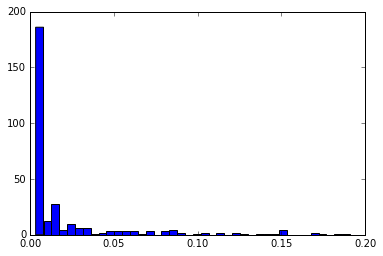

In [47]:
print np.mean(prob_tmp)

values = np.array([np.log10(proj_sep), np.log10(delta_v_trans)]).T
prob_out = np.exp(P_binary.binary_kde.score_samples(values))
plt.hist(prob_out[prob_out>0.0], bins=40)

print np.mean(prob_out)
print np.mean(prob_tmp * jacob_dV_dmu * jacob_ds_dtheta)
print np.mean(jacob_dV_dmu), np.mean(jacob_ds_dtheta)

#P_binary.get_P_binary(10**X.flatten(), 10**Y.flatten(), kde_method='sklearn')
plt.show()

### We can check the normalization here

In [152]:
# Set a random parallax
ran_plx = 100.0
ran_dist = 1.0e3/ran_plx


# Random draws
n_sys = 3000000
ran_delta_mu = 100000.0 * np.random.uniform(size=n_sys)
ran_theta = 1.0*np.random.uniform(size=n_sys)

# Convert to quantities we can use
ran_delta_v_trans = (ran_delta_mu/1.0e3/3600.0*np.pi/180.0) * ran_dist * (c.pc_to_cm/1.0e5) / (c.yr_to_sec)
ran_proj_sep = (ran_theta*np.pi/180.0) * ran_dist * (c.pc_to_cm / c.Rsun_to_cm)


# Set jacobians
jacob_dV_dmu = ran_dist * (c.pc_to_cm/1.0e5) * (1.0 / ((180.0/np.pi)*3600.0*1.0e3)) * (1.0 / c.yr_to_sec)
jacob_ds_dtheta = ran_dist * (np.pi/180.0) * (c.pc_to_cm / c.Rsun_to_cm)


# Calculate densities
values = np.array([np.log10(ran_proj_sep), np.log10(ran_delta_v_trans)]).T
prob_out = np.exp(P_binary.binary_kde.score_samples(values))
prob_out = prob_out * jacob_dV_dmu * jacob_ds_dtheta / ran_delta_v_trans / ran_proj_sep / np.log(10.)**2


# Average and divide by area to get value of the integral
area = 100000.0*1.0
print "This should approximate unity:", np.mean(prob_out) * area

This should approximate unity: 0.797362794381


### Let's calculate the overall number of stellar pairs

In [171]:
n_set = 10**np.linspace(2, 5, 10)
factor = np.zeros(10)

for i, num_sys in zip(np.arange(10), n_set):

    print i, num_sys
    
    # Monte Carlo select random positions
    ran_theta = np.arccos(1.0-2.0*np.random.uniform(size = num_sys))
    ran_phi = 2.0 * np.pi * np.random.uniform(size = num_sys)

    ran_dec = (ran_theta-np.pi/2.0) * 180.0/np.pi
    ran_ra = ran_phi * 180.0/np.pi

    # Calculate sigma^2
    sigma_pos = P_random.get_sigma_pos(ran_ra, ran_dec, catalog=tgas_full)
    sigma_pos_2 = sigma_pos**2

    
    factor[i] = np.mean(sigma_pos_2)
    
    
n_square_degrees = 41253.

plt.plot(n_set, n_square_degrees/(2.0*factor))
plt.xscale('log')

plt.show()

0 100.0
1 215.443469003
2 464.158883361
3 1000.0
4 2154.43469003
5 4641.58883361
6 10000.0
7 21544.3469003
8 46415.8883361
9 100000.0


/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
